In [1]:
import nmrglue as ng
import numpy as np
from cops_analysis import cops_analyze
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('..')
a = cops_analyze(['./pyruvate_HNCA/HNCA_nocop.ft3','./pyruvate_HNCA/HNCA_cop1.ft3','./pyruvate_HNCA/HNCA_cop3.ft3','./pyruvate_HNCA/HNCA_cop4.ft3','./pyruvate_HNCA/HNCA_cop5.ft3','./pyruvate_HNCA/HNCA_cop6.ft3'], mode='HNCA',pyruvate_on=True)

In [3]:
tb=pd.read_fwf('./files/GB1_new.shifts', infer_nrows=300)
tb = tb.drop(index=[0,1,2,3,4,5])
tb = tb.rename(columns={'w1':'CA','w2':'N','w3':'HN'})
tb.index = range(len(tb))
tb['is_sequential']=np.append([False], [len(tb['Assignment'][i+1]) > len(tb['Assignment'][i]) for i in range(len(tb)-1)])
#tb.loc[tb['is_sequential'],'CA']=tb[~tb['is_sequential']][['CA']][:-1].to_numpy() #enforce the same CA

#realign spectra
shifts_array = tb[['CA', 'N','HN']].to_numpy(dtype=np.float32)
shifts_array[:,[0,1]]=shifts_array[:,[1,0]]

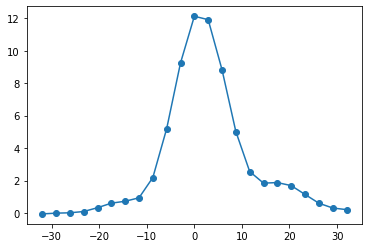

In [4]:
data = shifts_array[95] #18 for K27, #-4 for K49
hz, nocop_trace = a.extract1D(data, a.nocop_dat, a.nocop_unit_convs, sw=32, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

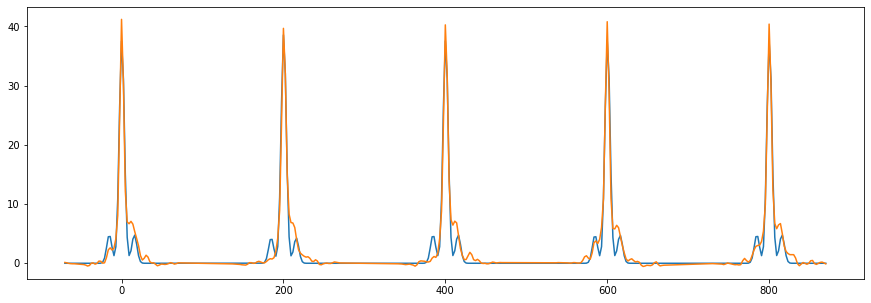

In [8]:
params,_ = a.CalcCB(data, sw=70, simple_output=False)

hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1],sw=70, normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i],sw=70, normalize=True)[1] for i in range(5)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(5)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, a.lineshape_Cb(hz, *params), hz_long, cop_1Ds)

In [12]:
np.array([a.extract1D(shifts_array[2], a.cop_dats[i], a.cop_unit_convs[i],sw=32, normalize=True)[1] 
                                 for i in range(5)]).reshape(-1).shape

(145,)

In [6]:
dslice_nocop = np.array([a.extract1D(shifts_array[j], a.nocop_dat, a.nocop_unit_convs,sw=32, C_offset=-0.09, normalize=True)[1] for j in range(len(shifts_array))])
dslice_nocop.shape

(103, 23)

In [9]:
dslice_cop = np.array([np.array([a.extract1D(shifts_array[j], a.cop_dats[i], a.cop_unit_convs[i],sw=32, normalize=True)[1] 
                                 for i in range(5)]).reshape(-1) 
                       for j in range(len(shifts_array))])
dslice_cop.shape 

(103, 145)

In [12]:
from sklearn.cluster import SpectralBiclustering

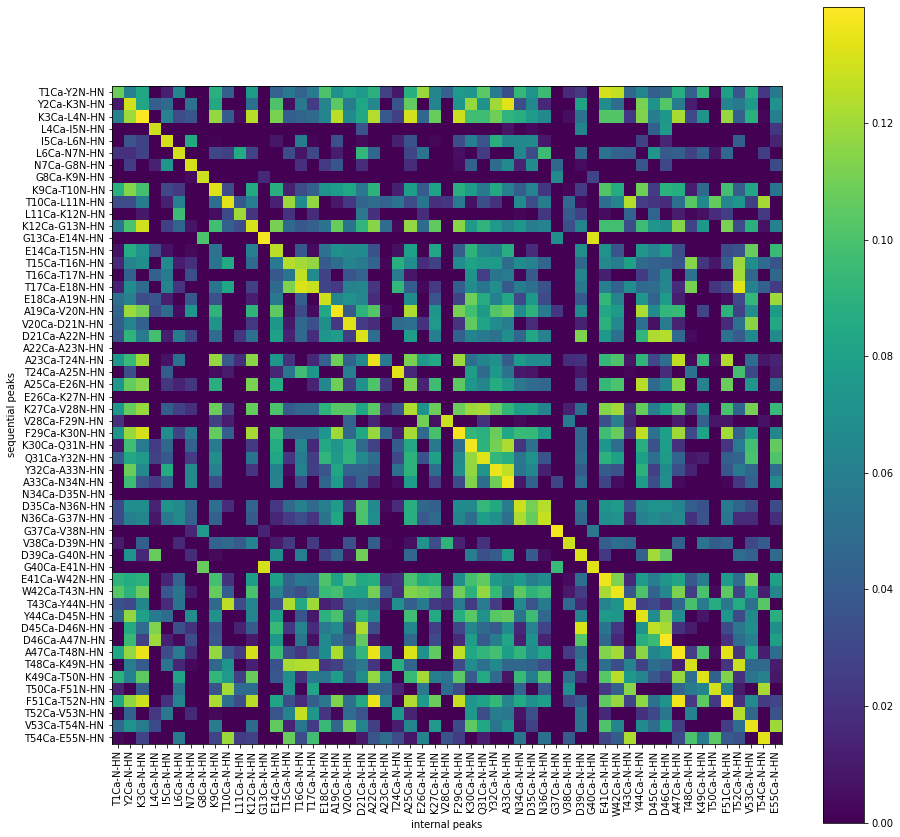

In [13]:
threshold=0.85#atm 0.92
data = np.append(dslice_nocop, dslice_cop, axis=1)
data_sequential = data[tb['is_sequential']]
data_internal = data[~tb['is_sequential']]
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
T[T<threshold] = threshold
T=T-threshold
plt.figure(figsize=[15,15])
plt.imshow(T)
plt.xticks(np.arange(55), tb[~tb['is_sequential']]['Assignment'], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), tb[tb['is_sequential']]['Assignment'], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

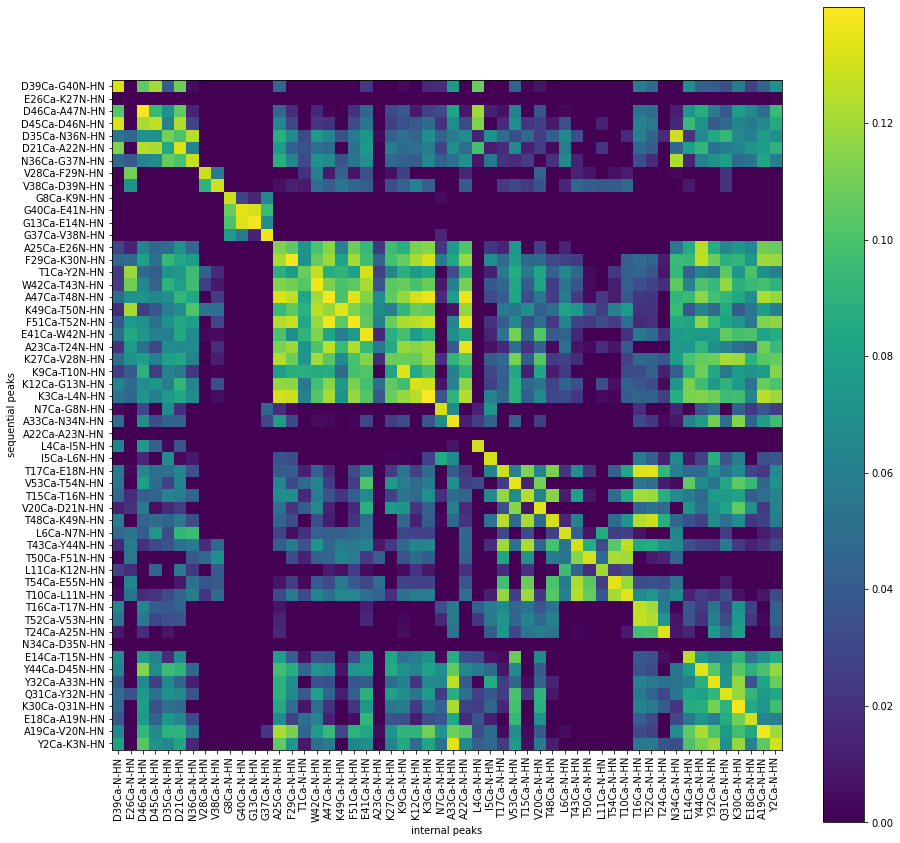

In [14]:
model = SpectralBiclustering(n_clusters=10)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

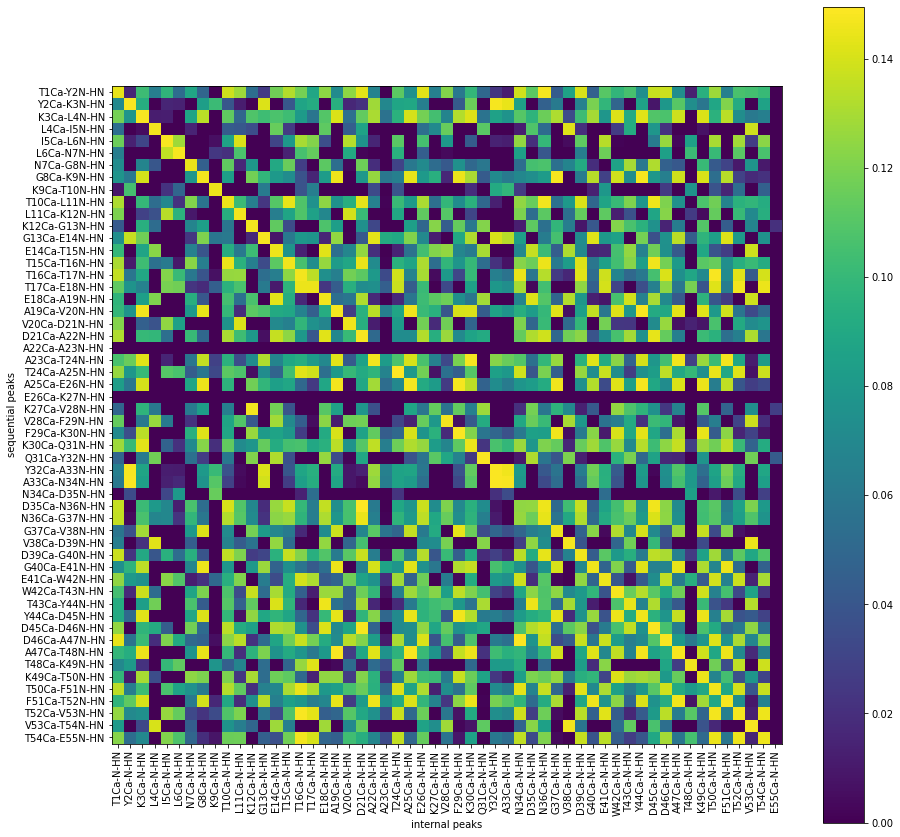

In [15]:
threshold=0.85 #0.95
data = dslice_nocop
data_sequential = data[tb['is_sequential']]
data_internal = data[~tb['is_sequential']]
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
T[T<threshold] = threshold
T=T-threshold
plt.figure(figsize=[15,15])
plt.imshow(T)

plt.xticks(np.arange(55), tb[~tb['is_sequential']]['Assignment'], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), tb[tb['is_sequential']]['Assignment'], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()


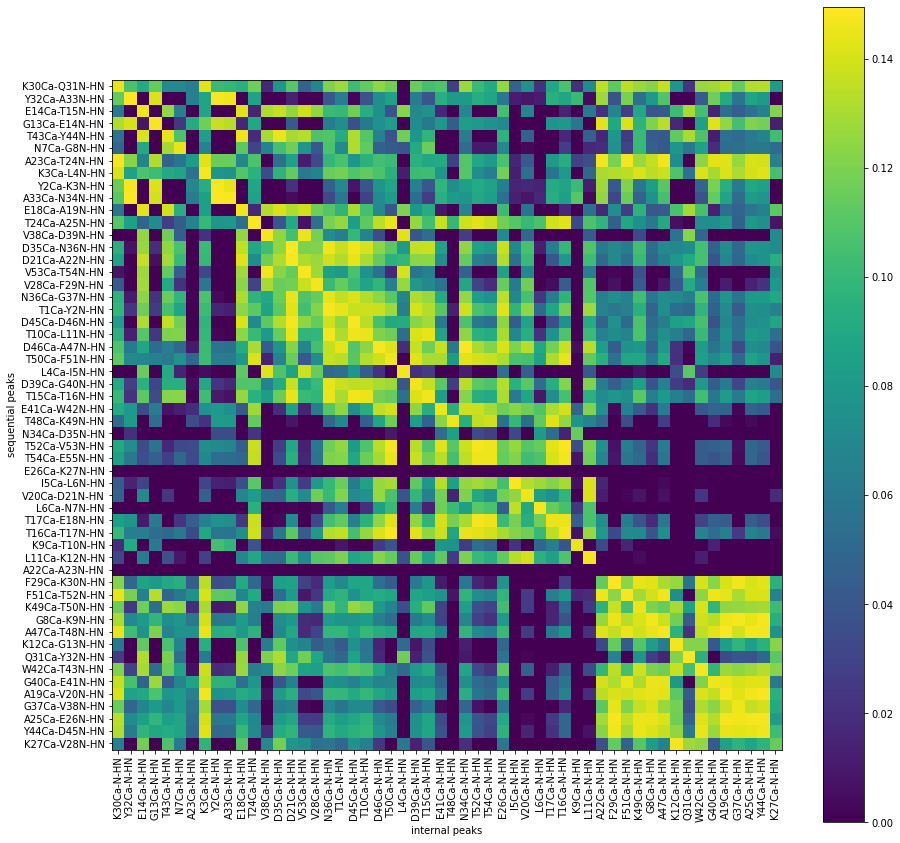

In [16]:
model = SpectralBiclustering(n_clusters=5)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

In [20]:
b = cops_analyze(['no_pyruvate/GB1_BCG1.ucsf','no_pyruvate/GB1_BCG3.ucsf','no_pyruvate/GB1_BCG4.ucsf','no_pyruvate/GB1_BCG5.ucsf','no_pyruvate/GB1_BCG6.ucsf',], mode='HCA',pyruvate_on=False)
tb_nopyr=pd.read_fwf('./no_pyruvate/GB1_BCG1.list', infer_nrows=300)
tb_nopyr = tb_nopyr.rename(columns={'w1':'CA','w2':'HN'})

#realign spectra
tb_nopyr = tb_nopyr.set_index(tb_nopyr['Assignment'])
tb_nopyr['is_sequential']=np.append([False], [len(tb_nopyr['Assignment'][i+1]) > len(tb_nopyr['Assignment'][i]) for i in range(len(tb_nopyr)-1)])
#tb_nopyr.loc[tb_nopyr['is_sequential'],'CA']=tb_nopyr[~tb_nopyr['is_sequential']][['CA']][:-1].to_numpy() #enforce the same CA

shifts_array = tb_nopyr[['CA', 'HN']].to_numpy(dtype=np.float32)

dslice_cop_nopyr = np.array([np.array([b.extract1D(shifts_array[j], b.cop_dats[i], b.cop_unit_convs[i],sw=90, normalize=True)[1] for i in range(5)]).reshape(-1) for j in range(len(shifts_array))])
dslice_cop_nopyr.shape 

(109, 195)

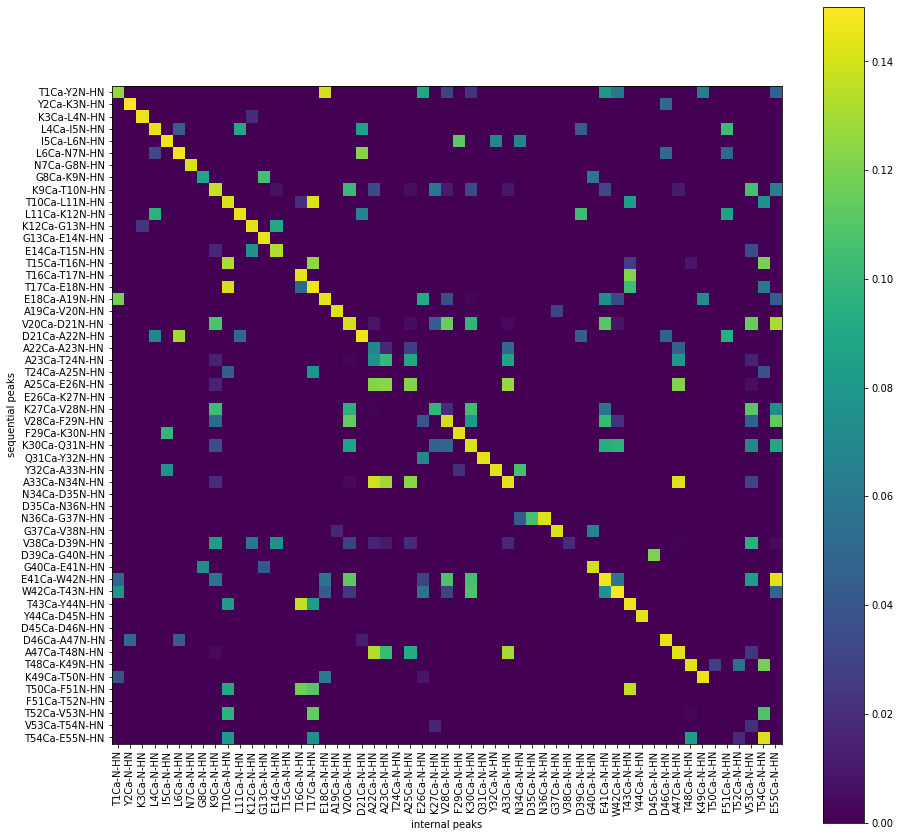

In [21]:
threshold=0.85
data = dslice_cop_nopyr
data_sequential = data[tb_nopyr['is_sequential']]
data_internal = data[~tb_nopyr['is_sequential']]
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
T[T<threshold] = threshold
T=T-threshold
plt.figure(figsize=[15,15])
plt.imshow(T)
plt.xticks(np.arange(55), tb[~tb['is_sequential']]['Assignment'], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), tb[tb['is_sequential']]['Assignment'], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

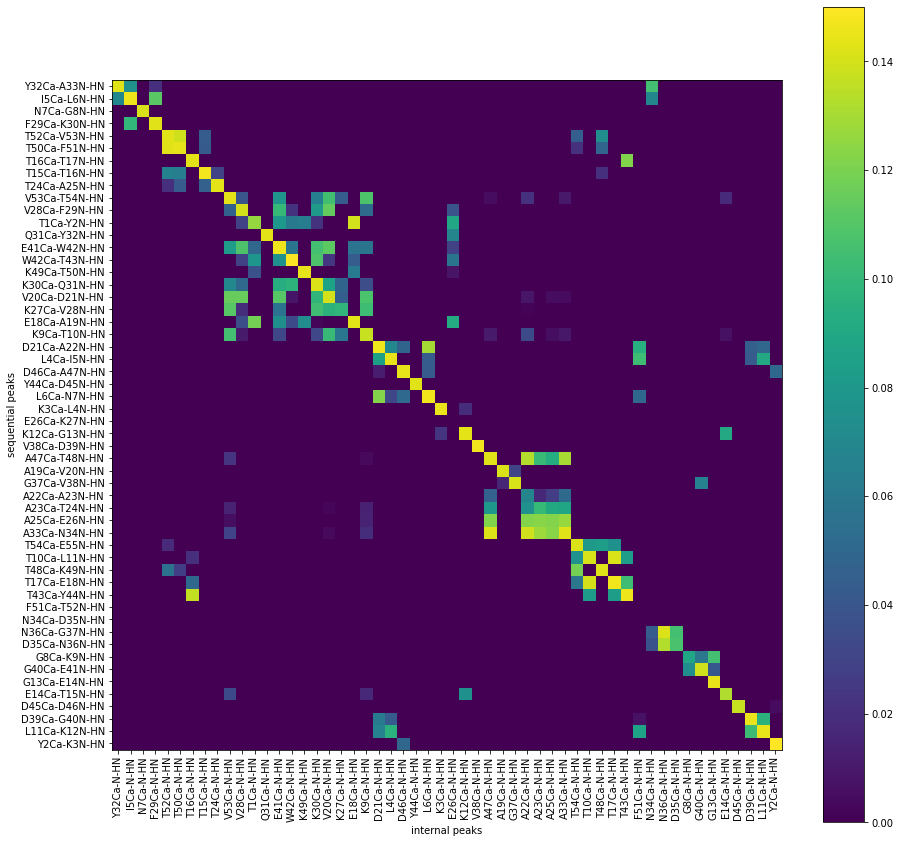

In [19]:
model = SpectralBiclustering(n_clusters=10)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

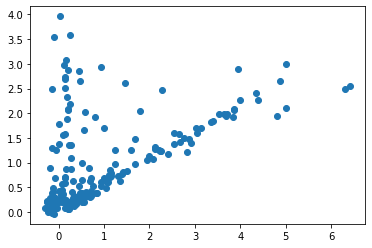

In [164]:
plt.scatter(data_internal[50], data_sequential[50])

[54.169 10.333]


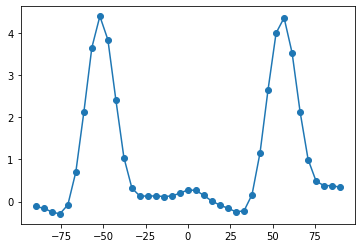

In [166]:
data = shifts_array[100] #18 for K27, #-4 for K49
print(shifts_array[100])
hz, nocop_trace = b.extract1D(data, b.cop_dats[0], b.cop_unit_convs[0], sw=90, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

In [162]:
tb[tb.index==95]

,Assignment,CA,N,HN,is_sequential
95,T48Ca-K49N-HN,57.392,124.024,7.71,True


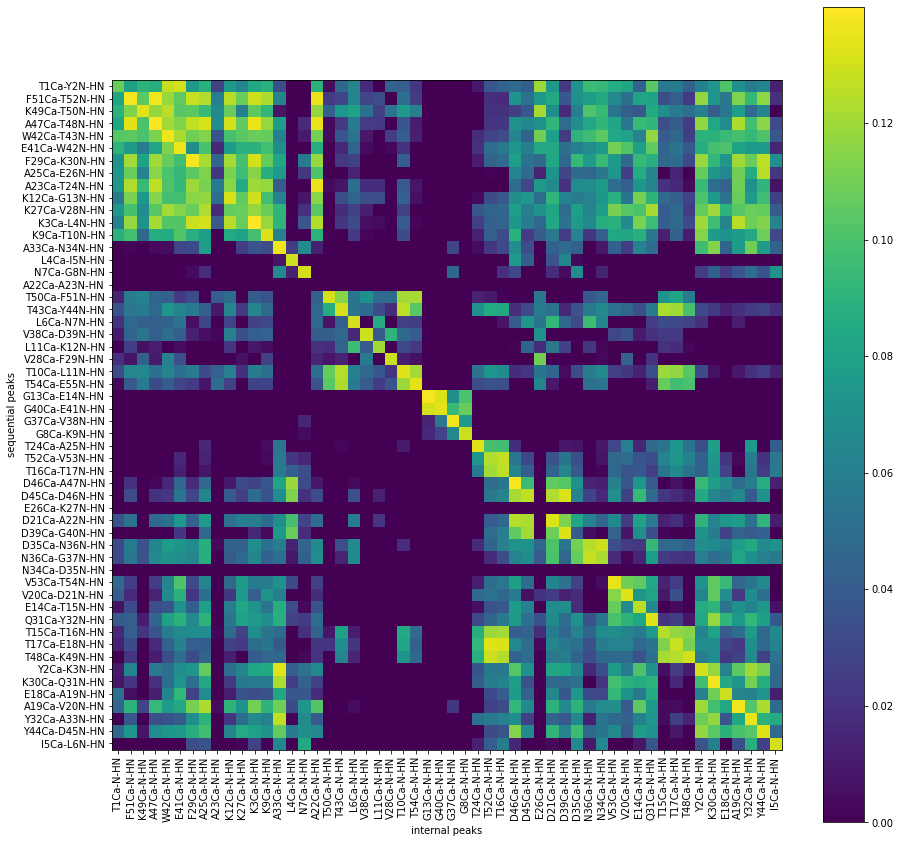

In [279]:
model = SpectralBiclustering(n_clusters=10)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

In [280]:
#clustering groups: 5 for pyruvate, 10 for pyruvate-cops, ?? for cops. this is stochastic